# Deep Nostalgia recreation using the paper "First Order Motion Model for Image Animation"

Recently there's a lot in news about Deep Nostalgia and about deepfakes in general. While I am not exactly sure which technique are the Deep Nostalgia folks using, there is an open source repository for a papr from 2019 which does exactly the same thing!

We can load information about the content and style of the face from one photo or painting (it will be Mona Lisa in this demo, because why not).
We can additionally load the information of facial features movement from a video.

The main difference with Deep Nostalgia is that they probably have higher quality results (this one is going to be 256x256 px) and that they might have a whole repository of these driving video animations.

This is mainly using the demo from https://github.com/AliaksandrSiarohin/first-order-model
I added few lines to download one of the videos covering results from Deep Nostalgia to get a sample movement video (the way their animated portraits move and look around).



> Feel free to "Runtime -> Run all".



**Clone repository**

In [1]:
!git clone https://github.com/AliaksandrSiarohin/first-order-model

Cloning into 'first-order-model'...
remote: Enumerating objects: 256, done.
remote: Total 256 (delta 0), reused 0 (delta 0), pack-reused 256
Receiving objects: 100% (256/256), 72.13 MiB | 40.40 MiB/s, done.
Resolving deltas: 100% (128/128), done.


In [2]:
cd first-order-model

/content/first-order-model


**Get the model weights from the authors of the paper**

In [3]:
# models:
!gdown https://drive.google.com/uc?id=1DbjXD2nS3jlyCWoJu2HGcLZZjhLC9a2J
#!gdown https://drive.google.com/uc?id=1iLxNvNo5IEHACs7e-FaMY4Oi98MjNDh8

Downloading...
From: https://drive.google.com/uc?id=1DbjXD2nS3jlyCWoJu2HGcLZZjhLC9a2J
To: /content/first-order-model/vox-cpk.pth.tar
729MB [00:03, 201MB/s]


In [4]:
# sample images
!gdown https://drive.google.com/uc?id=1cxEj-hSOr1LIHREf6qm4YeWnrQsDPRVA # < mona lisa

Downloading...
From: https://drive.google.com/uc?id=1cxEj-hSOr1LIHREf6qm4YeWnrQsDPRVA
To: /content/first-order-model/05.png
100% 168k/168k [00:00<00:00, 5.43MB/s]


More input images can be found in the folder https://drive.google.com/drive/folders/1kZ1gCnpfU0BnpdU47pLM_TQ6RypDDqgw?usp=sharing .
Alternativelly you can use this mirror link https://drive.google.com/drive/folders/16inDpBRPT1UC0YMGMX3dKvRnOUsf5Dhn?usp=sharing

**Load driving video and source image**

In [5]:
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")
from demo import make_animation
from skimage import img_as_ubyte

**Create a model and load checkpoints**

In [6]:
from demo import load_checkpoints
generator, kp_detector = load_checkpoints(config_path='config/vox-256.yaml', 
                                            checkpoint_path='vox-cpk.pth.tar')

## Getting our own data

We will use the slightly uncanny movement that the videos of Deep Nostalgia have - we can get it from their own videos directly (but note that we could have just used any other video of face talking and looking around ...)

In [7]:
# get a youtube downloader
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     3    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     3    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100   614  100   614    0     0    561      0  0:00:01  0:00:01 --:--:--   561
100 1781k  100 1781k    0     0  1541k      0  0:00:01  0:00:01 --:--:-- 1541k


In [8]:
youtube_url = "https://www.youtube.com/watch?v=251pfVoGBUA"

!youtube-dl -ci -f "bestvideo" $youtube_url -o 'youtube_video.mp4'

[youtube] 251pfVoGBUA: Downloading webpage
[download] Destination: youtube_video.mp4
[download] 100% of 11.44MiB in 00:00


Let's crop just the target face from the video - this little script serves as a visualization of what the crop command should be (note: yeah, we should ideally automate this).

(1080, 1920, 3)


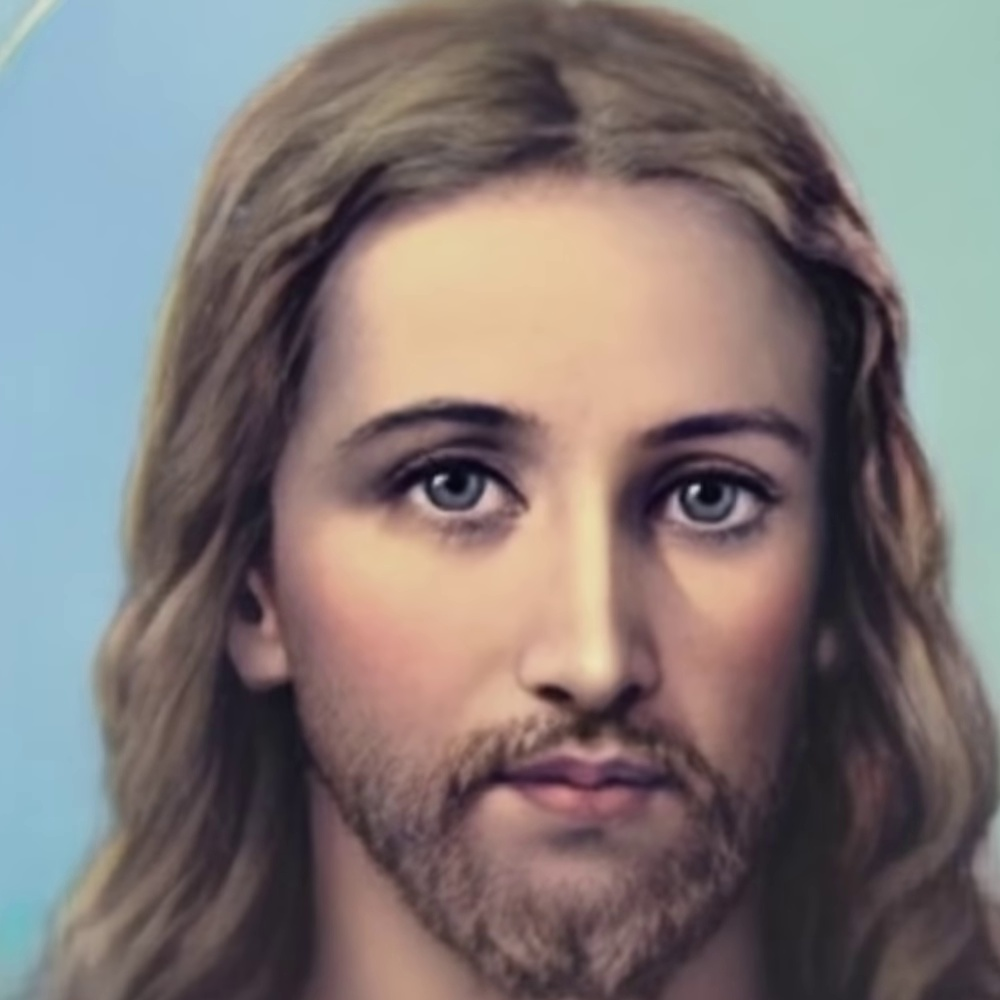

In [39]:
# First we need to find the face:
# this can be done manually by adjusting these:
y1 = 0
y2 = y1 + 1000
x1 = 800
x2 = x1 + 1000

###
x = x1
y = y1
out_w = y2-y1
out_h = x2-x1

def show_crop(video_name, frame_number=250):
  global y1, y2, x1, x2

  vidcap = cv2.VideoCapture(video_name)
  select_frame = frame_number

  success,image = vidcap.read()


  print(image.shape)

  count = 0
  while success:
    success,image = vidcap.read()

    if count == select_frame:
      cv2.imwrite("framefull.jpg", image)     # save frame as JPEG file      
      crop_img = image[y1:y2, x1:x2]
      #crop_img = image[y:y+h, x:x+w]

      cv2.imwrite("frame.jpg", crop_img)     # save frame as JPEG file      
      success = False

    #print('Read a new frame: ', success)
    count += 1


show_crop(video_name='youtube_video.mp4', frame_number=250)
from IPython.display import Image
#Image('framefull.jpg')
Image('frame.jpg', width=100, height=100)

Perfect! Now lets use this:

In [10]:
# change the command to this:
crop_command = '"crop='+str(out_w)+":"+str(out_h)+":"+str(x)+":"+str(y)+'"'

print(crop_command)

"crop=1000:1000:800:0"


You can also change the value in -ss (the starting time):

*(ps: if you want to animate from Jesus, change it to somewhere in the beginning...)*

But note that we are using only the animation that Deep Nostalgia assigned these faces ...

In [ ]:
#!ffmpeg -i youtube_video.mp4 -ss 00:01:02 -t 00:00:08 -filter:v "crop=1000:1000:800:0" -async 1 crop.mp4
!ffmpeg -i youtube_video.mp4 -ss 00:01:02 -t 00:00:08 -filter:v $crop_command -async 1 crop.mp4

# crop=out_w:out_h:x:y
# out_w is the width of the output rectangle
# out_h is the height of the output rectangle
# x and y specify the top left corner of the output rectangle

In [12]:
source_image = imageio.imread('05.png') # < load up mona lisa
reader = imageio.get_reader('crop.mp4')

#Resize image and video to 256x256

source_image = resize(source_image, (256, 256))[..., :3]

fps = reader.get_meta_data()['fps']
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()

driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

def display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    

HTML(display(source_image, driving_video).to_html5_video())

# Now we will be transplanting the movement from the right video on the left face:

*Another posibility is to use some screen recording tool, or if you need to crop many images at ones use face detector(https://github.com/1adrianb/face-alignment) , see https://github.com/AliaksandrSiarohin/video-preprocessing for preprcessing of VoxCeleb.*

In [14]:
source_image = imageio.imread('05.png')
driving_video = imageio.mimread('crop.mp4', memtest=False)


#Resize image and video to 256x256

source_image = resize(source_image, (256, 256))[..., :3]
driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True,
                             adapt_movement_scale=True)

HTML(display(source_image, driving_video, predictions).to_html5_video())

100%|██████████| 240/240 [00:08<00:00, 28.06it/s]


In [18]:
# save the video
fps = 30
imageio.mimsave("result_video.mp4", [img_as_ubyte(frame) for frame in predictions], fps=fps)

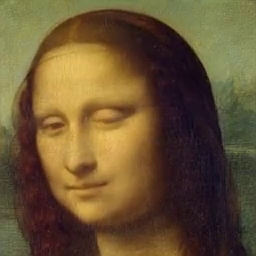

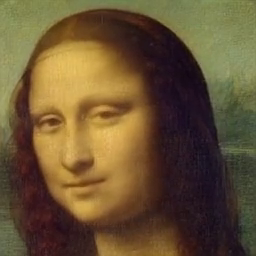

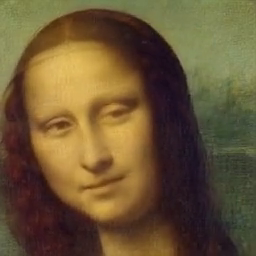

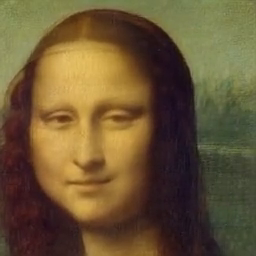

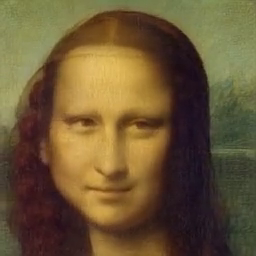

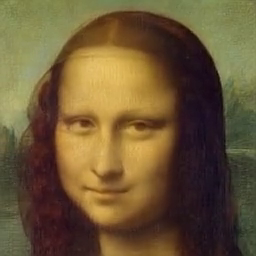

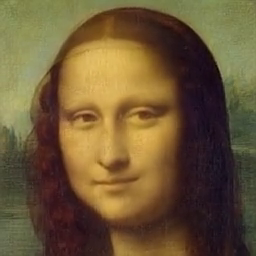

In [38]:
from google.colab.patches import cv2_imshow

sample_every = 30
i = 0

cap = cv2.VideoCapture('result_video.mp4')
while cap.isOpened():
    ret, image = cap.read()

    if not ret:
      break

    i += 1
    if i > sample_every:
      cv2_imshow(image) # Note cv2_imshow, not cv2.imshow
      i = 0

    cv2.waitKey(1) & 0xff

cv2.destroyAllWindows()
cap.release()


In [35]:
!ls result_video.mp4 -luah

-rw-r--r-- 1 root root 95K Mar 18 23:32 result_video.mp4


In [20]:
from google.colab import files
files.download('result_video.mp4') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>